# Chapter 7.1 -- Fitting a Tree

This Chapter deals with the creation of a tree.
It shows how the mutlimodal distribution is used.

It also shows some plotting with the tree.

In [1]:
#
# L O A D I N G 
#
# The distributions are implemented in a sub module inside the pyYggdrasil module
import pyYggdrasil.Random as pyR

# We also need the normal part of pyYggdrasil
import pyYggdrasil as pyY

# We also need numpy 
import numpy as np

# We also need plotting
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# Needed for the gauss kernel
from scipy import stats

In [2]:
# For that we also need an appropriate source of randomness.
geni = pyR.pRNG(42) 

## Distribution Object
Before we can start we must create a distribution object.
Since we want to use the multimodal distribution we must first create the model

### Creating the modes
We will use three modes, that are all composed of gaussians.

In [3]:
#
# Here we are generating the modes

# This is the domain we use
domain = pyY.HyperCube(2, pyY.Interval(-15, 15))


# First mode
Sigma1 = np.matrix([[2, 0], [0, 0.5]])
Mean1  = np.array([0, 0])
mode1  = pyR.Gauss(mu = Mean1, Sigma = Sigma1, domain = domain)

# This is the second mode
Sigma2 = np.matrix([[0.5, 0], [0, 0.5]])
Mean2  = np.array([3, 3])
mode2  = pyR.Gauss(mu = Mean2, Sigma = Sigma2, domain = domain)

# This is the thrid mode
Sigma3 = np.matrix([[1, 0], [0, 0.5]])
Mean3  = np.array([-3, 3])
mode3  = pyR.Gauss(mu = Mean3, Sigma = Sigma3, domain = domain)


### Now we Compose the Mode to a Distribution
For that we also need the weights.
The weights are choosen such that mode1 is as probable as the other two together.

In [4]:
# Wirst we must set up the weights; see above for the values
w1 = 0.5
w2 = 0.25
w3 = 0.25    # This is not needed, because it is defined by the two other weights

In [5]:
#
# Now the actual composing happens
# the create function is able to use up 5 modes
distri = pyR.creatMultiModal(w1 = w1, m1 = mode1, w2 = w2, m2 = mode2, m3 = mode3)

### A Samll Test
Now lets run a small test to verify if the distrubution works as intended.
The anaytic mean is easaly computed to be $(0, 1)^T$.
The covariance is more involved, but this is done by the distribution.

In [6]:
# This is the number of sampels that we generate for the testing
# It should be not sop large, because otherwhise the gauss smoother will run forever
aNotSoLargeNumberOfSamples = 2000

In [7]:
# Now we generate the test samples
# We will also use them for fitting the tree
testSamples, testSamples_pdf = distri.generateSamplesCollectionPDF(geni, aNotSoLargeNumberOfSamples)

#### Now we Make a Small Scatter Plot
This is just for visualization of the original data.

See "https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/20107592#20107592" for more.

The intention of the distribution is to look like a smilly, but it does not realy work.


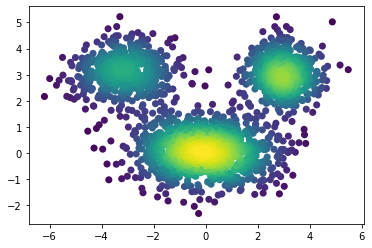

In [8]:
# First we have to load the dimension
# For that we use the second extension of the UCI.
# Note in C++ this operation is way faster on sample collections, but since in Python
# there is always a copy, all colections are equaly fast.

x = testSamples.getDimensionArray(0)
y = testSamples.getDimensionArray(1)

# Now we have to calculate the point density
# Calculate the point density
xy = np.vstack([x,y])
z  = stats.gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Plot it 
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()


## Generate a Tree
For that we need a large number of samples.
Thenj we fitt a tree and will finaly plot the distribution.

In [9]:
#
# First we need more samples
aRealyLargeNumberOfSamples = 200000

In [10]:
# Now generate the sample for the tree fitting
fitSamples, fitSamples_pdf = distri.generateSamplesCollectionPDF(geni, aRealyLargeNumberOfSamples)

In [11]:
#
# Generate a builder
b = pyY.TreeBuilder(pyY.eParModel.LinModel).setGOFLevel(0.0001).setIndepLevel(0.0001).useSizeSplitter()

# Print the builder
print("We will use the builder:")
print(b)

We will use the builder:
ParModel: Linear
Independence Test: Chi2;  \alpha = 0.0001
GOF Test: Chi2;  \alpha = 0.0001
Splitting: Const/Size


In [12]:
# 
# Now we will actually generate the tree
tree = pyY.DETree(domain = domain, builder = b, samples = fitSamples)

### Evaluate the PDF
Now we will evaluate the tree and the distribution.
For that we will use a very fine grid defined on the domain and perform numerical quadrature.

#### Generate the Grid
First we must generate the grid.
For that we use a helper function of Yggdrasil.
Note that this function is only able to handle one and two dimensions.

We will use a smaller domain for plotting and evaluation.
The reason is that othervise, we will not see much.

In [13]:
# This is the smaller plot domain
plotDomain = pyY.CREAT_INVALID_CUBE(2)
plotDomain.setInvalidDimension(0, pyY.Interval(-7.0, 7.0))
plotDomain.setInvalidDimension(1, pyY.Interval(-2.0, 7.0))

In [14]:
# We have not specified p2, the number of grids in the second dimension.
# This means that the value s the same as in the first dimension.
# We do not have a square domain, but it does not mather, it makes things easer for plotting
#    (Help on that mather is apreciated.)
# We also only generate inner points
p1 = 2000
grid = pyY.generateGrid(domain = plotDomain, p1 = p1, woLowest = True)

# Print the numbers of samples
print("We generated {} many samples".format(grid.nSamples()))

We generated 4000000 many samples


#### Get the PDF Values
We will now query the tree _and_ the distribution for the pdf values at that locations on the grid.

In [15]:
# Tree
# We use the error mode, sicne we have used the grid of
# the distribution for the tree
gridPDF_tree = tree.evaluateSamplesAt_err(x = grid)

# Distribution
gridPDF_exac = distri.pdf(grid)

#### MISE
We now calculate the MISE of the distribution.
Note that this is a bit useless since we should actually do a scaling analysis.

Note that we must do numerical integration, and no important sampling scheme.


In [16]:
# This is the volume element
volElem = plotDomain.getVol() / grid.nSamples()

In [17]:
# This is the MISE
MISE = volElem * ((gridPDF_exac - gridPDF_tree)**2).sum()

In [18]:
print("The MISE is {}".format(MISE))

The MISE is 0.0001393364328053954


#### Test of the Integration Domain
We will now integrate the pDF fucntions to see how much we have catured

In [19]:
# This is the mass of the exact pdf
exMass = volElem * gridPDF_exac.sum()

# This is the mass of the tree pdf
treeMass = volElem * gridPDF_tree.sum()

In [20]:
print("The probability mass of the exact distribution is: {}".format(exMass))
print("The probability mass of the tree estimator is:     {}".format(treeMass))

The probability mass of the exact distribution is: 0.999809555531844
The probability mass of the tree estimator is:     0.999711291269175


### Plotting
Now we will do some plotting.
For that see also "https://towardsdatascience.com/simple-example-of-2d-density-plots-in-python-83b83b934f67".
And "https://matplotlib.org/3.1.0/gallery/mplot3d/surface3d.html".

In [21]:
# First general prepariations are needed

# Getting the coordinates
xx = grid.getDimensionArray(0)
yy = grid.getDimensionArray(1)

# Plotting seams to need that
X = xx.reshape((p1, p1))
Y = yy.reshape((p1, p1))

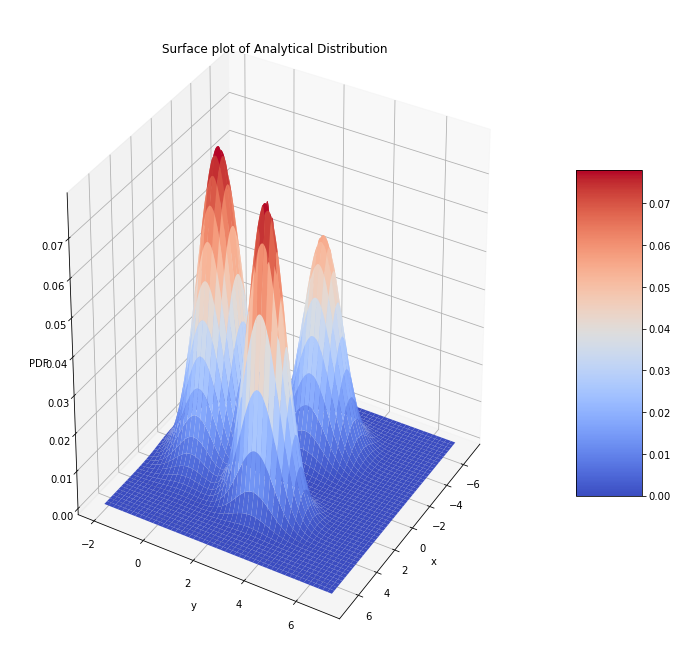

In [22]:
#
# Plotting the analytical pdf
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, gridPDF_exac.reshape(X.shape), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Analytical Distribution')
fig.colorbar(surf, shrink=0.5, aspect=5) 
ax.view_init(azim=30)
plt.show()


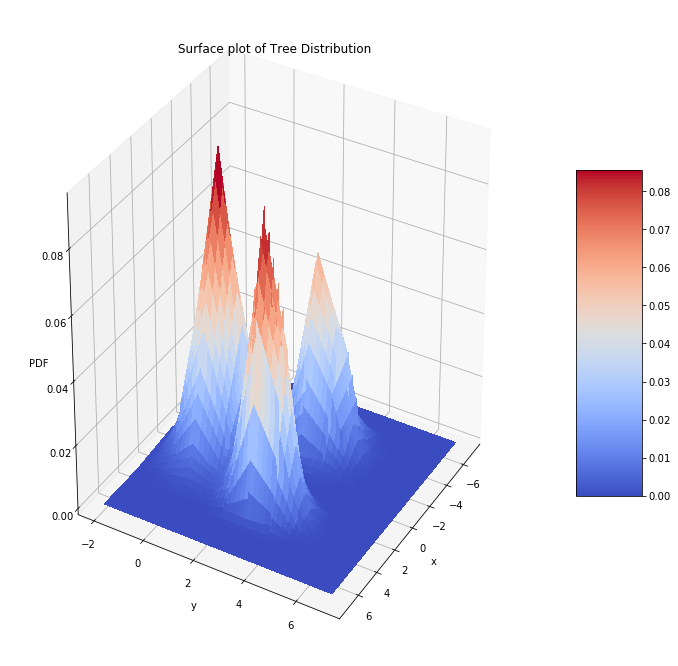

In [23]:
#
# Plotting the tree pdf
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, gridPDF_tree.reshape(X.shape), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Tree Distribution')
fig.colorbar(surf, shrink=0.5, aspect=5) 
ax.view_init(azim=30)
plt.show()


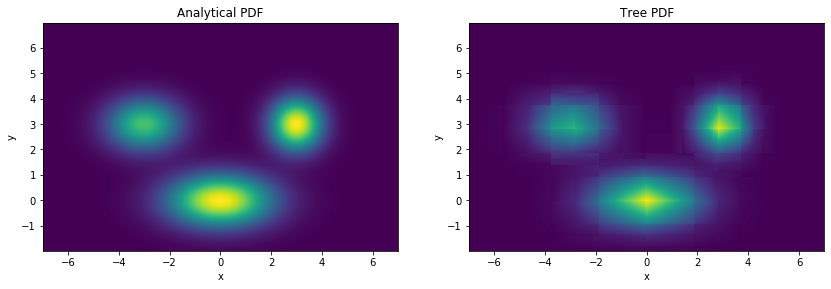

In [24]:
#
# Color plot (top view)

fig = plt.figure(figsize=(14, 14))


# Exact PDF
ax = fig.add_subplot(1, 2, 1, aspect=1)
ax.pcolormesh(X, Y, gridPDF_exac.reshape(X.shape))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Analytical PDF")

# Tree PDF
ax = fig.add_subplot(1, 2, 2, aspect=1)
ax.pcolormesh(X, Y, gridPDF_tree.reshape(X.shape))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Tree PDF")

# Show the plot
plt.show()



